In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 1. Write a python function to run an external edgeR analysis

In [2]:
def edgeR_run(infile, outfile):
    '''
    Uses R to run the edgeR program for differential gene analysis on transcript counts from two different biological 
    groups (i.e. mutant v. WT), with three biological replicates of each.  
    
    Parameters
    ----------
    
    infile: .tbl file 
        file that holds transcript counts of genes in a tab-delimited text file with 3 bioloigical replicates for
        each transcript count for each gene. 
    
    outfile: .tbl file 
        file that holds "logFC" "logCPM" "PValue" "FDR" values which are output from the edgeR analysis for each 
        gene
    
    Returns
    -------
    
    resultdf: pandas DataFrame
        DataFrame holding the information for each gene from the outfile to use in python. 
    
    '''
    
    #write the R script
    with open("R_script.r", "w") as Rfile:
        Rfile.write("library(edgeR) \n")
        Rfile.write("infile     <- '{}' \n".format(infile))
        Rfile.write("group      <- factor(c(1,1,1,2,2,2))\n")     
        Rfile.write("outfile    <- '{}' \n".format(outfile))

        Rfile.write("x     <- read.table(infile, sep='\t', row.names=1) \n")
        Rfile.write("y     <- DGEList(counts=x,group=group) \n")
        Rfile.write("y     <- estimateDisp(y) \n")
        Rfile.write("et    <- exactTest(y) \n")
        Rfile.write("tab   <- topTags(et, nrow(x)) \n")
        Rfile.write("\n")
        Rfile.write("write.table(tab, file=outfile) \n")
        
    !Rscript R_script.r
    
    resultdf = pd.read_csv(outfile, sep=" ")
    
    return resultdf
        

In [3]:
#test that the Rscript function actually works on the example given for the HW
!Rscript analyze_W.r.txt

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


In [4]:
#test that the function I've made works on the example infile given
result_edgeR_test = edgeR_run("mydata.tbl", "mydataoutex.tbl")

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


In [5]:
#check out results from the example dataset - gives what was asked for in the first part of the pset!
result_edgeR_test.head()

,logFC,logCPM,PValue,FDR
grapefruit,-7.591967,7.903049,1.867039e-33,3.739865e-29
kohlrabi,-7.107483,8.558358,5.417357e-31,3.176049e-27
rosemary,-7.098623,8.843683,5.594040e-31,3.176049e-27
plum,-7.085908,9.893074,6.342268e-31,3.176049e-27
mustard,-7.042437,11.870897,1.479755e-30,5.928193e-27


# 2. Reproduce Wiggins' data, assign the missing labels

In [6]:
#read in data files and turn into dataframes to work with them
data_df1 = pd.read_csv("w08-data.1.txt", sep="\t")
data_df2 = pd.read_csv("w08-data.2.txt", sep="\t")
data_df3 = pd.read_csv("w08-data.3.txt", sep="\t")

In [7]:
#create possible combinations of samples to test which two are mutant v. WT and which one is WT v. WT
df12 = pd.merge(data_df1, data_df2, on="#gene")
df23 = pd.merge(data_df2, data_df3, on="#gene")
df13 = pd.merge(data_df1, data_df3, on="#gene")

In [8]:
#need to turn merged dataframes into files for use in R function
df12.to_csv("w08-data.12.txt", sep="\t", index=None)
df23.to_csv("w08-data.23.txt", sep="\t", index=None)
df13.to_csv("w08-data.13.txt", sep="\t", index=None)

In [9]:
#run function on dataset merge 1-2
result_edgeR12 = edgeR_run("w08-data.12.txt", "w08-data.12_out.txt")

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


In [10]:
#run function on dataset merge 2-3
result_edgeR23 = edgeR_run("w08-data.23.txt", "w08-data.23_out.txt")

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


In [11]:
#run function on dataset merge 1-3
result_edgeR13 = edgeR_run("w08-data.13.txt", "w08-data.13_out.txt")

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


In [12]:
#make sure getting expected results - first look
result_edgeR12.head()

,logFC,logCPM,PValue,FDR
melon,-7.567569,12.950843,5.207330e-34,1.043080e-29
carrot,-7.412580,11.661138,5.899989e-33,5.909134e-29
onion,-7.401122,10.372209,9.418965e-33,6.289043e-29
clementine,-7.301346,8.519468,5.865505e-32,2.937298e-28
radish,-7.107316,10.114258,4.643946e-31,1.860458e-27


In [13]:
#count number of genes in merged dataset which have "significant" p-values
result_edgeR12.loc[result_edgeR12["PValue"] <= 0.05].count()

logFC     2135
logCPM    2135
PValue    2135
FDR       2135
dtype: int64

In [14]:
#count number of genes in merged dataset which have "significant" p-values
result_edgeR23.loc[result_edgeR23["PValue"] <= 0.05].count()

logFC     996
logCPM    996
PValue    996
FDR       996
dtype: int64

In [15]:
#count number of genes in merged dataset which have "significant" p-values
result_edgeR13.loc[result_edgeR13["PValue"] <= 0.05].count()

logFC     2049
logCPM    2049
PValue    2049
FDR       2049
dtype: int64

Wiggins has run the first and second sample groups together for his analysis based on the number of differentially expressed genes having a p-value greater than 0.05. The controls are sample groups 2 and 3 and the mutant is sample group 1 since groups 1 and 3 and 2 and 3 have the most (and a similar number of) differentially expressed genes, whereas 2 and 3 have far fewer differentially expressed genes when compared to each other. 

# 3. Wiggins doesn't understand p-values

I do not agree with Wiggins. About 5% of the 2135 differentially expressed genes could be randomly differentially expressed - so about 100 of the differentially expressed genes could be randomly differentially expressed. When looking at the wild-type samples and comparing them, there are over that many differentially expressed genes, making this metric for distinguishing between the wild-type and mutant unreliable. We should actually be using the FDR here, instead. 

In [16]:
#count number of genes in merged dataset which have low false discovery rates
result_edgeR12.loc[result_edgeR12["FDR"] <= 0.05].count()

logFC     69
logCPM    69
PValue    69
FDR       69
dtype: int64

In [17]:
#count number of genes in merged dataset which have low false discovery rates
result_edgeR23.loc[result_edgeR23["FDR"] <= 0.05].count()

logFC     0
logCPM    0
PValue    0
FDR       0
dtype: int64

In [18]:
#count number of genes in merged dataset which have low false discovery rates
result_edgeR13.loc[result_edgeR13["FDR"] <= 0.05].count()

logFC     76
logCPM    76
PValue    76
FDR       76
dtype: int64

Using the FDR as a statistical cutoff with the same numerical value yields no differentially expressed genes between the wild-type samples and at least 69 differentially expressed genes between the wild-type (2,3) and mutant (1) sample groups. 

# 4. Wiggins missed something else too

In order to get a better sense of the data that the edgeR outputs, I will do some visualization exercises. 

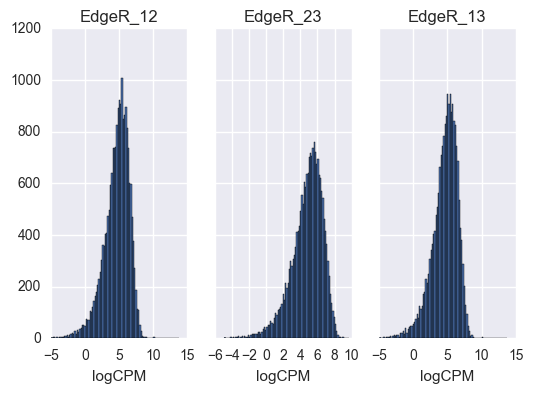

In [19]:
#try looking at logCPM alone
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

ax1.hist(result_edgeR12['logCPM'], bins=100)
ax1.set_title("EdgeR_12")
ax1.set_xlabel('logCPM')

ax2.hist(result_edgeR23['logCPM'], bins=100)
ax2.set_title("EdgeR_23")
ax2.set_xlabel('logCPM')

ax3.hist(result_edgeR13['logCPM'], bins=100)
ax3.set_title("EdgeR_13")
ax3.set_xlabel('logCPM')

The two compared control samples seem to have a slightly wider distribution of logCPM values than the other two compared samples. 

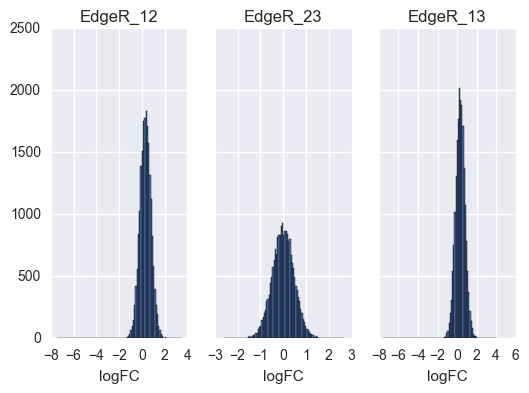

In [20]:
#try looking at logFC alone
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

ax1.hist(result_edgeR12['logFC'], bins=100)
ax1.set_title("EdgeR_12")
ax1.set_xlabel("logFC")

ax2.hist(result_edgeR23['logFC'], bins=100)
ax2.set_title("EdgeR_23")
ax2.set_xlabel("logFC")

ax3.hist(result_edgeR13['logFC'], bins=100)
ax3.set_title("EdgeR_13")
ax3.set_xlabel("logFC")

The same trend observed for logCPM values seems to be even more pronounced in the logFC value distribution for each set of compared groups. 

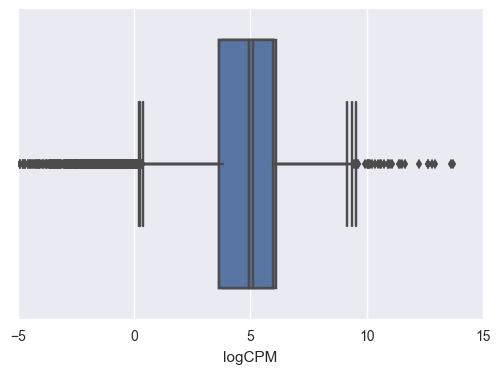

In [21]:
#try looking at boxplots
sns.boxplot(result_edgeR12['logCPM'])
sns.boxplot(result_edgeR23['logCPM'])
sns.boxplot(result_edgeR13['logCPM'])

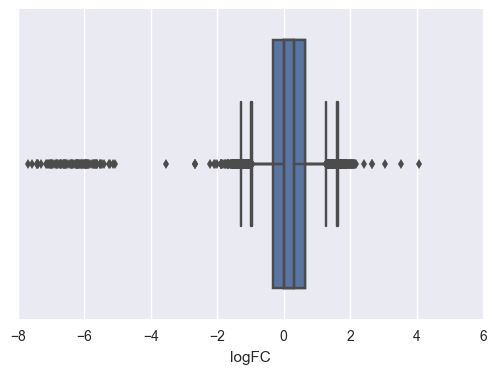

In [22]:
#try looking at boxplots
sns.boxplot(result_edgeR12['logFC'])
sns.boxplot(result_edgeR23['logFC'])
sns.boxplot(result_edgeR13['logFC'])

Actually I didn't find this use of boxplots very informative, but I've included it here to show that I tried to use it to visualize the data differently. 

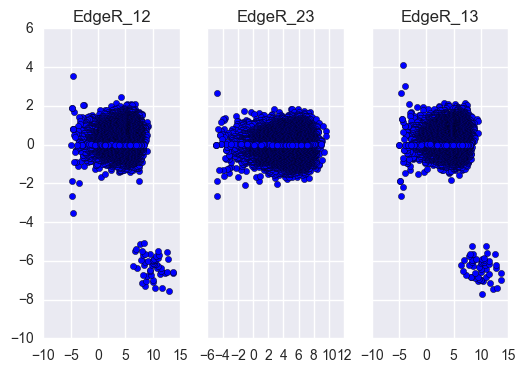

In [23]:
#try plotting the logCPM by logFC
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

ax1.scatter(result_edgeR12['logCPM'], result_edgeR12['logFC'])
ax1.set_title("EdgeR_12")

ax2.scatter(result_edgeR23['logCPM'], result_edgeR23['logFC'])
ax2.set_title("EdgeR_23")

ax3.scatter(result_edgeR13['logCPM'], result_edgeR13['logFC'])
ax3.set_title("EdgeR_13")


It seems like each of the wild-type to mutant have outliers when comparing the logFC to logCPM values, likely corresponding to the differentially expressed genes, especially since we don't see this subclustering of values in the comparison between wild-type groups. There are some very large fold changes (see below), but some of them may overlap with the genes that aren't actually differentially expressed. However, we can use the logCPM values, which are correlated with the logFC values, as a naive way to find which genes are differentially expressed. We can see from the scatterplot visualiation that the values which seem to be differentially expressed have logFC values below -4.  

In [24]:
result_edgeR13.sort_values("logFC").head(60)

,logFC,logCPM,PValue,FDR
radish,-7.710223,10.110706,5.812656e-34,1.164333e-29
anise,-7.434325,12.253413,2.243284e-32,1.995470e-28
melon,-7.414251,12.951691,2.988572e-32,1.995470e-28
carrot,-7.152563,11.662800,8.166828e-31,4.089743e-27
onion,-7.041222,10.374611,3.214438e-30,1.207967e-26
chard,-7.029040,9.498554,3.618291e-30,1.207967e-26
quince,-6.997394,10.053880,5.559759e-30,1.496060e-26
wasabi,-6.991804,10.063166,5.974978e-30,1.496060e-26
fig,-6.973156,13.722502,8.804400e-30,1.959566e-26
sage,-6.938922,9.632748,1.155728e-29,2.315040e-26


In [25]:
result_edgeR12.loc[result_edgeR12["logFC"] < -4].count()

logFC     50
logCPM    50
PValue    50
FDR       50
dtype: int64

In [26]:
#how many genes are both within the FDR cutoff, but would be excluded using the logFC cutoff
result_edgeR12.loc[(result_edgeR12["logFC"] > -4) & (result_edgeR12["FDR"] < 0.05)].count()

logFC     19
logCPM    19
PValue    19
FDR       19
dtype: int64

Seems to be exactly the excess number of genes expected, based on the number of genes within the FDR cutoff (69)

In [27]:
result_edgeR23.loc[result_edgeR23["logFC"] < -4].count()

logFC     0
logCPM    0
PValue    0
FDR       0
dtype: int64

In [28]:
#how many genes are both within the FDR cutoff, but would be excluded using the logFC cutoff
result_edgeR23.loc[(result_edgeR23["logFC"] > -4) & (result_edgeR23["FDR"] < 0.05)].count()

logFC     0
logCPM    0
PValue    0
FDR       0
dtype: int64

Good. Expected nothing to change when comparing the WT groups to each other. 

In [29]:
result_edgeR13.loc[result_edgeR13["logFC"] < -4].count()

logFC     50
logCPM    50
PValue    50
FDR       50
dtype: int64

In [30]:
#how many genes are both within the FDR cutoff, but would be excluded using the logFC cutoff
result_edgeR13.loc[(result_edgeR13["logFC"] > -4) & (result_edgeR13["FDR"] < 0.05)].count()

logFC     26
logCPM    26
PValue    26
FDR       26
dtype: int64

Seems to be exactly the excess number of genes expected, based on the number of genes within the FDR cutoff (76)

### So what is happening? ... 

The relative abundances of each of the transcript counts depends on other genes, and when we have genes with such a high count number, it skews the relative abundances of transcripts, so that if there are genes where there is a very high count number, the logfold change of all other genes has to decrease as well, making it seem like these genes are differentially expressed, when really this is an indirect effect from a massively overexpressed gene. We can correct for this in the edgeR function by adding the TMM normalization feature to the function that is already written from part 1. 


In [31]:
def edgeR_run_norm(infile, outfile):
    '''
    Uses R to run the edgeR program for differential gene analysis on transcript counts from two different biological 
    groups (i.e. mutant v. WT), with three biological replicates of each. This version includes the TMM normalization 
    step - using a weighted trimmed mean of the log expression ratios  to correct for the effect of genes with larger 
    counts having a lower variance on the log scale (Robinson and Oshlack, 2010). 
    
    Parameters
    ----------
    
    infile: .tbl file 
        file that holds transcript counts of genes in a tab-delimited text file with 3 bioloigical replicates for
        each transcript count for each gene. 
    
    outfile: .tbl file 
        file that holds "logFC" "logCPM" "PValue" "FDR" values which are output from the edgeR analysis for each 
        gene
    
    Returns
    -------
    
    resultdf: pandas DataFrame
        DataFrame holding the information for each gene from the outfile to use in python. 
    
    '''
    
    #write the R script
    with open("R_script.r", "w") as Rfile:
        Rfile.write("library(edgeR) \n")
        Rfile.write("infile     <- '{}' \n".format(infile))
        Rfile.write("group      <- factor(c(1,1,1,2,2,2))\n")     
        Rfile.write("outfile    <- '{}' \n".format(outfile))

        Rfile.write("x     <- read.table(infile, sep='\t', row.names=1) \n")
        Rfile.write("y     <- DGEList(counts=x,group=group) \n")
        #TMM normalization
        Rfile.write("y     <- calcNormFactors(y) \n")
        Rfile.write("y     <- estimateDisp(y) \n")
        Rfile.write("et    <- exactTest(y) \n")
        Rfile.write("tab   <- topTags(et, nrow(x)) \n")
        Rfile.write("\n")
        Rfile.write("write.table(tab, file=outfile) \n")
        
    !Rscript R_script.r
    
    resultdf = pd.read_csv(outfile, sep=" ")
    
    return resultdf
        

In [32]:
result_edgeR12_norm = edgeR_run_norm("w08-data.12.txt", "w08-data.12_out_norm.txt")

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


In [33]:
result_edgeR23_norm = edgeR_run_norm("w08-data.23.txt", "w08-data.23_out_norm.txt")

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


In [34]:
result_edgeR13_norm = edgeR_run_norm("w08-data.13.txt", "w08-data.13_out_norm.txt")

Loading required package: limma
Design matrix not provided. Switch to the classic mode.


In [35]:
result_edgeR12_norm.loc[result_edgeR12_norm["FDR"] <= 0.05].count()

logFC     53
logCPM    53
PValue    53
FDR       53
dtype: int64

In [36]:
result_edgeR23_norm.loc[result_edgeR23_norm["FDR"] <= 0.05].count()

logFC     0
logCPM    0
PValue    0
FDR       0
dtype: int64

In [37]:
result_edgeR13_norm.loc[result_edgeR13_norm["FDR"] <= 0.05].count()

logFC     52
logCPM    52
PValue    52
FDR       52
dtype: int64

In [38]:
#check out the pandas DataFrame of the transcript counts (now normalized) of each gene for groups 1 (mutant) and 2 (WT)
#which have an FDR of at least 0.05
result_edgeR12_norm.loc[result_edgeR12_norm["FDR"] <= 0.05]

,logFC,logCPM,PValue,FDR
melon,-7.883256,13.106453,7.448672e-36,1.492043e-31
carrot,-7.728337,11.816293,8.903684e-35,8.917485e-31
onion,-7.715469,10.527586,1.515384e-34,1.011822e-30
clementine,-7.615986,8.674901,1.035424e-33,5.185145e-30
radish,-7.422717,10.270226,7.506175e-33,3.007124e-29
leek,-7.440522,8.238727,1.105183e-32,3.689652e-29
tangerine,-7.383394,8.997487,1.654583e-32,4.734708e-29
wasabi,-7.283719,10.219337,4.678097e-32,1.171337e-28
kohlrabi,-7.120627,9.056401,5.025987e-31,1.118617e-27
cherry,-7.018215,11.539524,1.089747e-30,2.182873e-27


In [39]:
#try more stringent FDR 
result_edgeR12_norm.loc[result_edgeR12_norm["FDR"] <= 0.001].count()

logFC     50
logCPM    50
PValue    50
FDR       50
dtype: int64

In [40]:
#check out the pandas DataFrame of the transcript counts (now normalized) of each gene for groups 1 (mutant) and 3 (WT) 
#which have an FDR of at least 0.05
result_edgeR13_norm.loc[result_edgeR13_norm["FDR"] <= 0.05]

,logFC,logCPM,PValue,FDR
radish,-8.030000,10.269261,9.660446e-36,1.935084e-31
anise,-7.753510,12.411284,3.876196e-34,3.478977e-30
melon,-7.733254,13.109340,5.210390e-34,3.478977e-30
carrot,-7.471262,11.819724,1.421712e-32,7.119579e-29
onion,-7.360053,10.531289,5.522730e-32,2.061690e-28
chard,-7.347516,9.655916,6.175499e-32,2.061690e-28
quince,-7.316172,10.210841,9.533900e-32,2.551428e-28
wasabi,-7.311038,10.220866,1.018992e-31,2.551428e-28
fig,-7.292107,13.879705,1.562206e-31,3.476949e-28
sage,-7.257371,9.789649,1.983275e-31,3.972699e-28


In [41]:
#try more stringent FDR
result_edgeR13_norm.loc[result_edgeR13_norm["FDR"] <= 0.001].count()

logFC     50
logCPM    50
PValue    50
FDR       50
dtype: int64

In [42]:
#assign df objects to compare genes included in each df in next cell
result_edgeR12_norm_df = result_edgeR12_norm.loc[result_edgeR12_norm["FDR"] <= 0.001]
result_edgeR13_norm_df = result_edgeR13_norm.loc[result_edgeR13_norm["FDR"] <= 0.001]

In [43]:
#show that the same genes are differentially expressed
set(result_edgeR12_norm_df.index) - set(result_edgeR13_norm_df.index)

set()

### In conclusion... 

There are a few (2 in one comparison and 3 in the other) genes that appear to just make the cutoff using FDR as a statistical cutoff at 0.05, which are not shared among the two compared sets of wild-type v. mutant datasets. If we make the FDR more stringent, however, we get a consistent number of genes differentially expressed between the mutant and two different wild-type sample groups. Additionally, the differentially expressed genes are the same between the two different comparisons between mutant and each wild-type sample group. 